### Experiment 1: Quantile prediction with switching data

We consider a data sequence that switches between 0 and 1. Based on this data sequence, we compare our algorithm with baselines for predicting the median. 

First, we initialize the experiment.

In [61]:
import sys
sys.path.append('./src')

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'lines.linewidth': 3})

from BayesianQuantile import BayesianQuantilePredictor
from Baselines import EmpiricalQuantilePredictor, SingleOGD, MultiValidPrediction
import utils

T = 50
data = [1,0] * int(T/2)
queried_confidence = 0.7

Next, we compute the total loss of the considered algorithms.

In [62]:
# Our algorithm. We use the inexact version with 50 bins.

myBayesian = BayesianQuantilePredictor(exact=False)
bayesian_predictions = np.zeros(T)
bayesian_loss = np.zeros(T)
for t in range(T):
    bayesian_predictions[t] = myBayesian.output(queried_confidence)
    bayesian_loss[t] = utils.quantile_loss(bayesian_predictions[t], data[t], queried_confidence)
    myBayesian.update(data[t])
bayesian_total_loss = np.cumsum(bayesian_loss)

# ERM

myEmpirical = EmpiricalQuantilePredictor()
empirical_predictions = np.zeros(T)
empirical_loss = np.zeros(T)
for t in range(T):
    empirical_predictions[t] = myEmpirical.output(queried_confidence)
    empirical_loss[t] = utils.quantile_loss(empirical_predictions[t], data[t], queried_confidence)
    myEmpirical.update(data[t])
empirical_total_loss = np.cumsum(empirical_loss)

# OGD with a known quantile level. Here the initialization is at 0.5, and the learning rate is 1/sqrt(t)

myOGD = SingleOGD(queried_confidence)
ogd_predictions = np.zeros(T)
ogd_loss = np.zeros(T)
for t in range(T):
    ogd_predictions[t] = myOGD.output()
    ogd_loss[t] = utils.quantile_loss(ogd_predictions[t], data[t], queried_confidence)
    myOGD.update(data[t])
ogd_total_loss = np.cumsum(ogd_loss)

Quite different from the above algorithms, we also test the MVP algorithm from (Bastani et al., 2022), following the authors' original implementation. Note that MVP is (only slightly) randomized, whereas the above algorithms are deterministic. 

In [63]:
# MVP is designed for the more general group-conditional CP problem. Without covariates, we only consider a single group including all rounds. 

def all_points(x):
    return True

basic_group = [all_points]
num_groups = len(basic_group)

# MVP requires specifying the number of buckets. We use the default choice 50, which is the same as the number of bins used by our algorithm. The rest of the hyperparameters are standard.

n_buckets = 50
K_e = 2.12
eta_MVP = np.sqrt(np.log(num_groups * n_buckets) / (2 * K_e * num_groups * n_buckets))

myMVP = MultiValidPrediction(delta=1-queried_confidence, groups=basic_group, eta=eta_MVP, seed=1)
mvp_predictions = np.zeros(T)
mvp_loss = np.zeros(T)
for t in range(T):
    mvp_predictions[t] = myMVP.predict(t)
    mvp_loss[t] = utils.quantile_loss(mvp_predictions[t], data[t], queried_confidence)
    myMVP.update(x=t, threshold=mvp_predictions[t], score=data[t])
mvp_total_loss = np.cumsum(mvp_loss)

Next, we evaluate the comparator. Since the data can only take the values of 0 or 1, the quantile loss becomes linear on the domain [0,1], which means the optimal comparator is 0 or 1. 

In [64]:
comparator_loss_0 = np.zeros(T)
comparator_loss_1 = np.zeros(T)
for t in range(T):
    comparator_loss_0[t] = utils.quantile_loss(0, data[t], queried_confidence)
    comparator_loss_1[t] = utils.quantile_loss(1, data[t], queried_confidence)
comparator_total_loss = np.minimum(np.cumsum(comparator_loss_0), np.cumsum(comparator_loss_1))

Finally we plot the regret of all the algorithms.

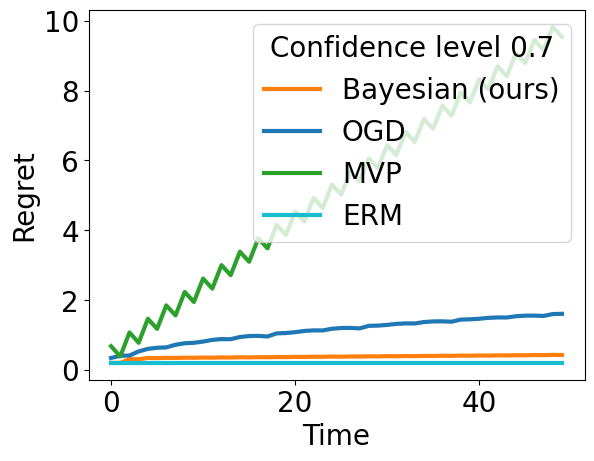

In [65]:
plt.plot(bayesian_total_loss - comparator_total_loss, label='Bayesian (ours)', color='#ff7f0e')
plt.plot(ogd_total_loss - comparator_total_loss, label='OGD', color='#1f77b4')
plt.plot(mvp_total_loss - comparator_total_loss, label='MVP', color='#2ca02c')
plt.plot(empirical_total_loss - comparator_total_loss, label='ERM', color='#17becf')
plt.legend(title=f'Confidence level {queried_confidence}',loc="upper right")
plt.xlabel('Time')
plt.ylabel('Regret')

plt.savefig(f"Figures/switching_{int(queried_confidence * 100)}_percent.pdf", bbox_inches='tight')
plt.show()